# Phase 1: Data Cleaning & Dual-Target Generation

## Objectives
1. Load 8 years of BTC hourly OHLCV data from Binance
2. Handle missing hours using domain-appropriate interpolation
3. Implement Garman-Klass volatility estimator
4. **Create dual predictive targets**:
   - `target_reg`: Next-hour GK volatility (regression)
   - `target_class`: Next-hour candle direction (binary classification)
5. Validate data quality and save cleaned dataset

---

## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 6)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load dataset
DATA_FILE = Path('btc_1h_data_2018_to_2025.csv')
print(f"Loading data from: {DATA_FILE}")

df = pd.read_csv(DATA_FILE)

# Display basic info
print(f"\nLoaded {len(df):,} hourly records")
print(f"Date range: {df.iloc[0]['Open time'] if 'Open time' in df.columns else 'N/A'} to {df.iloc[-1]['Open time'] if 'Open time' in df.columns else 'N/A'}")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")

Loading data from: btc_1h_data_2018_to_2025.csv

Loaded 70,823 hourly records
Date range: 2018-01-01 00:00:00.000000  to nan

Dataset shape: (70823, 12)

Column names:
['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']


In [3]:
# Data types and missing values summary
print("Data Types:")
print(df.dtypes)
print("\n" + "="*60)
print("Missing Values Summary:")
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_summary[missing_summary['Missing_Count'] > 0])

if missing_summary['Missing_Count'].sum() == 0:
    print("\n✓ No missing values detected!")
else:
    print(f"\n⚠ Total missing values: {missing_summary['Missing_Count'].sum():,}")

Data Types:
Open time                        object
Open                            float64
High                            float64
Low                             float64
Close                           float64
Volume                          float64
Close time                       object
Quote asset volume              float64
Number of trades                  int64
Taker buy base asset volume     float64
Taker buy quote asset volume    float64
Ignore                            int64
dtype: object

Missing Values Summary:
            Missing_Count  Missing_Percentage
Open time               1                 0.0
Close time              1                 0.0

⚠ Total missing values: 2


---
## 2. Data Cleaning & Missing Value Handling

In [4]:
# Standardize column names (lowercase)
df.columns = df.columns.str.lower()

# Parse timestamp columns if they exist
if 'open time' in df.columns:
    df['open time'] = pd.to_datetime(df['open time'])
    df = df.sort_values('open time').reset_index(drop=True)
    print("Open time parsed")

if 'close time' in df.columns:
    df['close time'] = pd.to_datetime(df['close time'])
    print("Close time parsed")


Open time parsed
Close time parsed


In [5]:
# Filter out 2026-02-03 records
if 'open time' in df.columns:
    initial_count = len(df)
    df = df[df['open time'].dt.date != pd.to_datetime('2026-02-03').date()].copy()
    removed_count = initial_count - len(df)
    print(f"Removed {removed_count:,} records from 2026-02-03")
    print(f"  Dataset reduced from {initial_count:,} to {len(df):,} rows")
else:
    print("No 'open time' or 'timestamp' column found to filter by date")

Removed 22 records from 2026-02-03
  Dataset reduced from 70,823 to 70,801 rows


In [6]:
# Check for and remove duplicate timestamps first
initial_count = len(df)
duplicates = df.duplicated(subset=['open time'], keep='first').sum()

if duplicates > 0:
    print(f"Found {duplicates:,} duplicate timestamps - removing duplicates (keeping first occurrence)")
    df = df.drop_duplicates(subset=['open time'], keep='first').reset_index(drop=True)
    print(f"  Dataset reduced from {initial_count:,} to {len(df):,} rows")

# Create expected hourly range
expected_range = pd.date_range(
    start=df['open time'].min(),
    end=df['open time'].max(),
    freq='1H'
)

expected_count = len(expected_range)
actual_count = len(df)
missing_hours = expected_count - actual_count

print(f"\nExpected hourly records: {expected_count:,}")
print(f"Actual records: {actual_count:,}")
print(f"Missing hours: {missing_hours:,} ({missing_hours/expected_count*100:.2f}%)")

if missing_hours > 0:
    print("Temporal gaps detected need reindex and interpolate")
    
    # Reindex to complete hourly series
    df = df.set_index('open time').reindex(expected_range).reset_index()
    df = df.rename(columns={'index': 'open time'})
    
    print(f"Reindexed to {len(df):,} hourly records")
else:
    print("No temporal gaps - data is complete!")


Found 2 duplicate timestamps - removing duplicates (keeping first occurrence)
  Dataset reduced from 70,801 to 70,799 rows

Expected hourly records: 70,920
Actual records: 70,799
Missing hours: 121 (0.17%)
Temporal gaps detected need reindex and interpolate
Reindexed to 70,920 hourly records


In [7]:
# Flag interpolated rows
df['is_interpolated'] = df[['open', 'high', 'low', 'close']].isnull().any(axis=1).astype(int)
interpolated_count = df['is_interpolated'].sum()
print(f"Rows requiring interpolation: {interpolated_count:,} ({interpolated_count/len(df)*100:.2f}%)")

Rows requiring interpolation: 122 (0.17%)


In [8]:
# Handle missing values by type
print("Applying interpolation")

# ohlc columns: Linear interpolation 

price_cols = ['open', 'high', 'low', 'close']
for col in price_cols:
    if col in df.columns:
        before_nulls = df[col].isnull().sum()
        df[col] = df[col].interpolate(method='linear', limit_direction='both')
        after_nulls = df[col].isnull().sum()
        print(f"{col.upper()}: Interpolated {before_nulls - after_nulls} missing values")

# close time from open time+1
if 'close time' in df.columns:
    close_nulls = df['close time'].isnull().sum()
    if close_nulls > 0:
        df['close time'] = df['close time'].fillna(df['open time'] + pd.Timedelta(hours=1))
        print(f"CLOSE TIME: Derived {close_nulls} missing values (open time + 1 hour)")

# other numeric columns: Zero-filling interpolation assuming no trading activity
numeric_cols = df.select_dtypes(include=[np.number]).columns
other_cols = [col for col in numeric_cols if col not in price_cols]

if len(other_cols) > 0:
    print(f"Zero-filling {len(other_cols)} non-price numeric columns:")
    for col in other_cols:
        before_nulls = df[col].isnull().sum()
        if before_nulls > 0:
            df[col] = df[col].fillna(0)
            after_nulls = df[col].isnull().sum()
            print(f"{col.upper()}: Zero-filled {before_nulls - after_nulls} missing values")

print("Interpolation complete")
print(f"Remaining nulls: {df.isnull().sum().sum()}")


Applying interpolation
OPEN: Interpolated 122 missing values
HIGH: Interpolated 122 missing values
LOW: Interpolated 122 missing values
CLOSE: Interpolated 122 missing values
CLOSE TIME: Derived 122 missing values (open time + 1 hour)
Zero-filling 7 non-price numeric columns:
VOLUME: Zero-filled 122 missing values
QUOTE ASSET VOLUME: Zero-filled 122 missing values
NUMBER OF TRADES: Zero-filled 122 missing values
TAKER BUY BASE ASSET VOLUME: Zero-filled 122 missing values
TAKER BUY QUOTE ASSET VOLUME: Zero-filled 122 missing values
IGNORE: Zero-filled 122 missing values
Interpolation complete
Remaining nulls: 0


In [9]:
# Validate price consistency
print("Validating OHLC price consistency...\n")

issues = []

# Check 1: High >= Low
invalid_hl = (df['high'] < df['low']).sum()
if invalid_hl > 0:
    issues.append(f"{invalid_hl} rows where High < Low")
else:
    print("All High >= Low")

# Check 2: High >= Open and Close
invalid_ho = (df['high'] < df['open']).sum()
invalid_hc = (df['high'] < df['close']).sum()
if invalid_ho > 0 or invalid_hc > 0:
    issues.append(f"High < Open: {invalid_ho}, High < Close: {invalid_hc}")
else:
    print("All High >= Open and Close")

# Check 3: Low <= Open and Close
invalid_lo = (df['low'] > df['open']).sum()
invalid_lc = (df['low'] > df['close']).sum()
if invalid_lo > 0 or invalid_lc > 0:
    issues.append(f"Low > Open: {invalid_lo}, Low > Close: {invalid_lc}")
else:
    print("All Low <= Open and Close")

# Check 4: No zero or negative prices
invalid_prices = ((df[price_cols] <= 0).sum(axis=1) > 0).sum()
if invalid_prices > 0:
    issues.append(f"{invalid_prices} rows with price <= 0")
else:
    print("No zero or negative prices")

if issues:
    print("\n" + "\n".join(issues))
    print("need manual inspection or outlier removal")
else:
    print("All OHLC validations passed!")

Validating OHLC price consistency...

All High >= Low
All High >= Open and Close
All Low <= Open and Close
No zero or negative prices
All OHLC validations passed!


---
## 3. Garman-Klass Volatility Implementation

In [10]:
def garman_klass_volatility(open_price, high_price, low_price, close_price):
    """
    Compute Garman-Klass (1980) volatility estimator.
    
    Formula:
    GK = sqrt(0.5 * [log(H/L)]^2 - (2*log(2) - 1) * [log(C/O)]^2)
    
    Parameters:
    -----------
    open_price : float
        Opening price of interval
    high_price : float
        Highest price during interval
    low_price : float
        Lowest price during interval
    close_price : float
        Closing price of interval
    
    Returns:
    --------
    float : Garman-Klass volatility estimate (returns NaN for invalid prices)
    
    Reference:
    ----------
    Garman, M. B., & Klass, M. J. (1980). On the estimation of security price 
    volatilities from historical data. Journal of Business, 53(1), 67-78.
    """
    # check nans
    if any(pd.isna([open_price, high_price, low_price, close_price])):
        return np.nan
    # check p<= 0
    if any(p <= 0 for p in [open_price, high_price, low_price, close_price]):
        return np.nan
    
    # Compute log ratios
    hl_ratio = np.log(high_price / low_price)
    co_ratio = np.log(close_price / open_price)
    
    # Garman-Klass formula
    gk = np.sqrt(
        0.5 * hl_ratio**2 - (2 * np.log(2) - 1) * co_ratio**2
    )
    
    return gk

print("Garman-Klass function defined -> garman_klass_volatility(open, high, low, close)")

Garman-Klass function defined -> garman_klass_volatility(open, high, low, close)


In [11]:
# Apply Garman-Klass formula to entire dataset
print("Calculate GK volatility for all intervals")

df['gk_volatility'] = df.apply(
    lambda row: garman_klass_volatility(
        row['open'], 
        row['high'], 
        row['low'], 
        row['close']
    ),axis=1)

# check NaN values
gk_nulls = df['gk_volatility'].isnull().sum()
print(f"GK volatility for {len(df) - gk_nulls:,} intervals")
if gk_nulls > 0:
    print(f"{gk_nulls} NaN values (due to invalid prices)")

Calculate GK volatility for all intervals
GK volatility for 70,920 intervals
GK volatility for 70,920 intervals


In [12]:
# Descriptive statistics for GK volatility
print("Garman-Klass Volatility Statistics:")
print("=" * 60)
print(df['gk_volatility'].describe())

# Identify potential outliers (>3 std deviations)
gk_mean = df['gk_volatility'].mean()
gk_std = df['gk_volatility'].std()
outlier_threshold = gk_mean + 3 * gk_std
outliers = (df['gk_volatility'] > outlier_threshold).sum()

print(f"\nPotential outliers (>3σ): {outliers} ({outliers/len(df)*100:.3f}%)")
print(f"Outlier threshold: {outlier_threshold:.6f}")

Garman-Klass Volatility Statistics:
count    70920.000000
mean         0.005783
std          0.005502
min          0.000000
25%          0.002674
50%          0.004311
75%          0.007066
max          0.213448
Name: gk_volatility, dtype: float64

Potential outliers (>3σ): 1124 (1.585%)
Outlier threshold: 0.022289


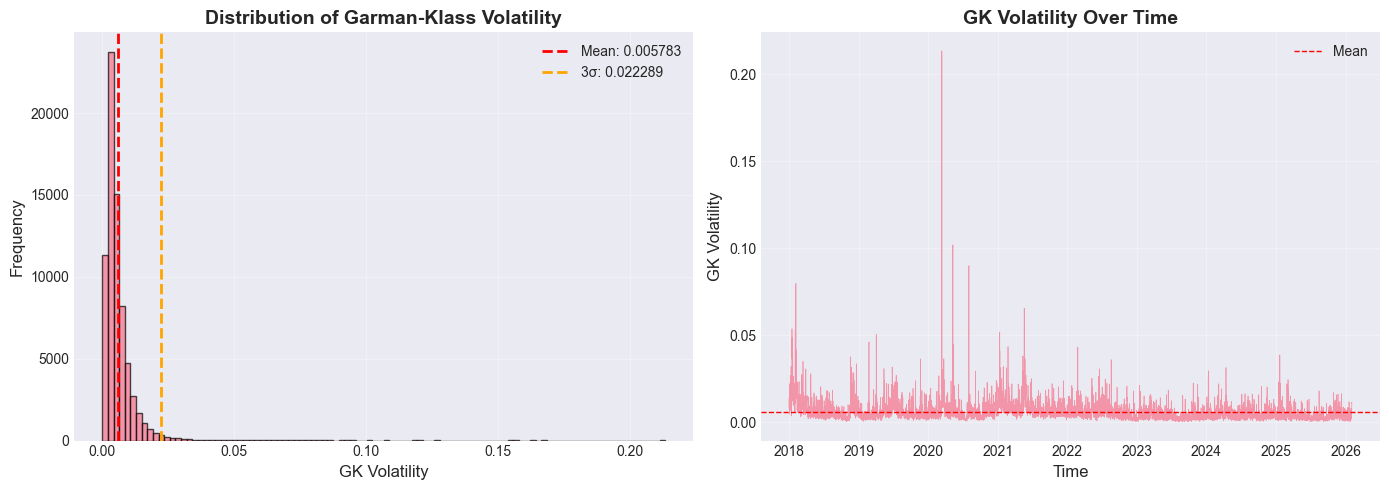

In [13]:
# Visualize GK volatility distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['gk_volatility'].dropna(), bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(gk_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {gk_mean:.6f}')
axes[0].axvline(outlier_threshold, color='orange', linestyle='--', linewidth=2, label=f'3σ: {outlier_threshold:.6f}')
axes[0].set_xlabel('GK Volatility', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Garman-Klass Volatility', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Time series (downsampled for visibility if >10k points)
plot_df = df[['open time', 'gk_volatility']].dropna()
if len(plot_df) > 10000:
    plot_df = plot_df.iloc[::10]  # Plot every 10th point
axes[1].plot(plot_df['open time'], plot_df['gk_volatility'], linewidth=0.5, alpha=0.7)
axes[1].axhline(gk_mean, color='red', linestyle='--', linewidth=1, label='Mean')
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('GK Volatility', fontsize=12)
axes[1].set_title('GK Volatility Over Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


---
## 4. Dual-Target Variable Creation

In [14]:
# Create targets: regression (volatility) and classification (direction)
print("Creating dual target variables:\n")

# Target 1: Regression - Next hour's GK volatility
df['target_reg'] = df['gk_volatility'].shift(-1)
print("target_reg: Next-hour GK volatility (continuous)")

# Target 2: Classification - Next hour's candle direction
# 1 if next close > current close (bullish), 0 otherwise (bearish/equal)
df['target_class'] = (df['close'].shift(-1) > df['close']).astype(int)
print("target_class: Next-hour candle direction (binary)")

# Count valid targets
valid_reg = df['target_reg'].notna().sum()
valid_class = df['target_class'].notna().sum()
print(f"\nValid samples:")
print(f"  Regression target:      {valid_reg:,}")
print(f"  Classification target:  {valid_class:,}")
print(f"  (Last row has no future targets)")

# Remove last row (no future targets)
df_original_len = len(df)
df = df[:-1].copy()
print(f" Dropped last row: {df_original_len:,} → {len(df):,} rows")

Creating dual target variables:

target_reg: Next-hour GK volatility (continuous)
target_class: Next-hour candle direction (binary)

Valid samples:
  Regression target:      70,919
  Classification target:  70,920
  (Last row has no future targets)
 Dropped last row: 70,920 → 70,919 rows


In [16]:
# Verify data integrity for dual targets
print("="*70)
print("DUAL-TARGET VALIDATION")
print("="*70)

# 1. Regression Target Analysis
print("target_reg:")
print(f"  Mean volatility: {df['target_reg'].mean():.6f}")
print(f"  Std volatility:  {df['target_reg'].std():.6f}")
correlation_reg = df[['gk_volatility', 'target_reg']].corr().iloc[0, 1]
print(f"  Autocorrelation: {correlation_reg:.4f}")

if correlation_reg > 0.95:
    print("Very high correlation - may indicate trivial prediction")
elif correlation_reg > 0.5:
    print("Moderate correlation - volatility clustering detected (expected)")
else:
    print("Low correlation - prediction task is non-trivial")

# 2. Classification Target Analysis
print(f"Classification Target (target_class):")
class_counts = df['target_class'].value_counts().sort_index()
class_pct = df['target_class'].value_counts(normalize=True).sort_index() * 100

print(f"Down (0): {class_counts.get(0, 0):,} ({class_pct.get(0, 0):.2f}%)")
print(f"Up (1):   {class_counts.get(1, 0):,} ({class_pct.get(1, 0):.2f}%)")

# Check for severe class imbalance
imbalance_ratio = max(class_pct) / min(class_pct)
if imbalance_ratio > 1.5:
    print(f"  ⚠ Class imbalance detected (ratio: {imbalance_ratio:.2f}:1)")
    print("  → Consider class weighting or SMOTE in Phase 4 modeling")
else:
    print(f"Classes are balanced (ratio: {imbalance_ratio:.2f}:1)")

# 3. Data Leakage Check
print(f"Data Leakage Check:")
identical_rows_reg = (df['gk_volatility'] == df['target_reg']).sum()
print(f"  Rows where current GK == next GK: {identical_rows_reg} ({identical_rows_reg/len(df)*100:.2f}%)")
print("  (Some matches expected in stable market conditions)")

# 4. Target Correlation (Volatility vs Direction)
target_corr = df[['target_reg', 'target_class']].corr().iloc[0, 1]
print(f"Inter-Target Correlation:")
print(f"Corr(target_reg, target_class): {target_corr:.4f}")


print("\n" + "="*70)

DUAL-TARGET VALIDATION
target_reg:
  Mean volatility: 0.005783
  Std volatility:  0.005502
  Autocorrelation: 0.6492
Moderate correlation - volatility clustering detected (expected)
Classification Target (target_class):
Down (0): 34,863 (49.16%)
Up (1):   36,056 (50.84%)
Classes are balanced (ratio: 1.03:1)
Data Leakage Check:
  Rows where current GK == next GK: 0 (0.00%)
  (Some matches expected in stable market conditions)
Inter-Target Correlation:
Corr(target_reg, target_class): -0.0235



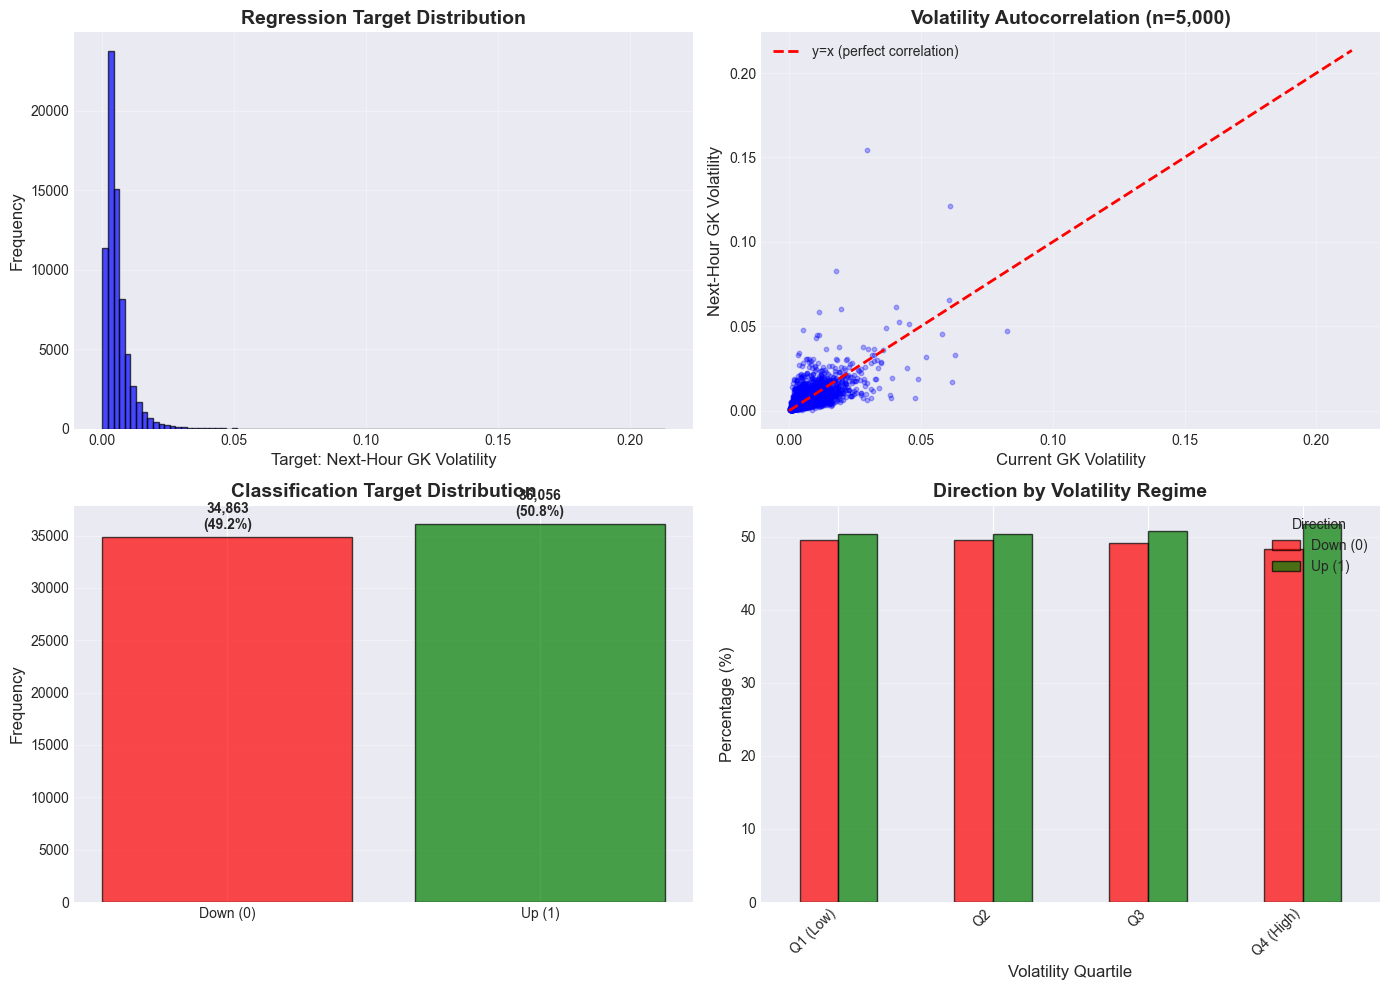

In [17]:
# Visualize dual-target distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Row 1: Regression Target
# 1.1 Target distribution
axes[0, 0].hist(df['target_reg'].dropna(), bins=100, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_xlabel('Target: Next-Hour GK Volatility', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Regression Target Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 1.2 Scatter: current vs next-hour volatility
sample_size = min(5000, len(df))
sample_df = df.sample(n=sample_size, random_state=42)
axes[0, 1].scatter(sample_df['gk_volatility'], sample_df['target_reg'], 
                   alpha=0.3, s=10, color='blue')
axes[0, 1].plot([df['gk_volatility'].min(), df['gk_volatility'].max()],
                [df['gk_volatility'].min(), df['gk_volatility'].max()],
                'r--', linewidth=2, label='y=x (perfect correlation)')
axes[0, 1].set_xlabel('Current GK Volatility', fontsize=12)
axes[0, 1].set_ylabel('Next-Hour GK Volatility', fontsize=12)
axes[0, 1].set_title(f'Volatility Autocorrelation (n={sample_size:,})', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Row 2: Classification Target
# 2.1 Class distribution
class_counts = df['target_class'].value_counts().sort_index()
colors = ['red', 'green']
axes[1, 0].bar(['Down (0)', 'Up (1)'], class_counts.values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Classification Target Distribution', fontsize=14, fontweight='bold')
for i, v in enumerate(class_counts.values):
    axes[1, 0].text(i, v + 500, f'{v:,}\n({v/len(df)*100:.1f}%)', 
                    ha='center', va='bottom', fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# 2.2 Class distribution by volatility regime
# Split volatility into quartiles
df['vol_quartile'] = pd.qcut(df['gk_volatility'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
vol_class_dist = df.groupby(['vol_quartile', 'target_class']).size().unstack(fill_value=0)
vol_class_pct = vol_class_dist.div(vol_class_dist.sum(axis=1), axis=0) * 100

vol_class_pct.plot(kind='bar', ax=axes[1, 1], color=['red', 'green'], alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Volatility Quartile', fontsize=12)
axes[1, 1].set_ylabel('Percentage (%)', fontsize=12)
axes[1, 1].set_title('Direction by Volatility Regime', fontsize=14, fontweight='bold')
axes[1, 1].legend(['Down (0)', 'Up (1)'], title='Direction')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# Clean up temporary column
df.drop('vol_quartile', axis=1, inplace=True)

---
## 5. Final Data Quality Report

In [18]:
print("\n" + "="*70)
print("PHASE 1 COMPLETION REPORT: DATA CLEANING & DUAL-TARGET GENERATION")
print("="*70)

print(f"Dataset Statistics:")
print(f"  • Total hourly records: {len(df):,}")
print(f"  • Time span: {df['open time'].min()} to {df['open time'].max()}")
total_days = (df['open time'].max() - df['open time'].min()).days
print(f"  • Duration: {total_days:,} days ({total_days/365.25:.1f} years)")

print(f"Data Cleaning:")
print(f"  • Interpolated rows: {df['is_interpolated'].sum():,} ({df['is_interpolated'].mean()*100:.2f}%)")
print(f"  • Remaining nulls: {df.isnull().sum().sum()}")

print(f"Garman-Klass Volatility:")
print(f"  • Valid GK calculations: {df['gk_volatility'].notna().sum():,}")
print(f"  • Mean volatility: {df['gk_volatility'].mean():.6f}")
print(f"  • Std volatility: {df['gk_volatility'].std():.6f}")
print(f"  • Min volatility: {df['gk_volatility'].min():.6f}")
print(f"  • Max volatility: {df['gk_volatility'].max():.6f}")

print(f"Regression Target (target_reg):")
print(f"  • Valid targets: {df['target_reg'].notna().sum():,}")
print(f"  • Target mean: {df['target_reg'].mean():.6f}")
correlation_reg = df[['gk_volatility', 'target_reg']].corr().iloc[0, 1]
print(f"  • Autocorrelation: {correlation_reg:.4f}")

print(f"Classification Target (target_class):")
print(f"  • Valid targets: {df['target_class'].notna().sum():,}")
class_counts = df['target_class'].value_counts().sort_index()
class_pct = df['target_class'].value_counts(normalize=True).sort_index() * 100
print(f"  • Down (0): {class_counts.get(0, 0):,} ({class_pct.get(0, 0):.2f}%)")
print(f"  • Up (1):   {class_counts.get(1, 0):,} ({class_pct.get(1, 0):.2f}%)")

print(f"Output Columns: {len(df.columns)}")
print(f"  {df.columns.tolist()}")

print("\n" + "="*70)
print("✓ PHASE 1 COMPLETE - Ready for Dual-Task Feature Engineering")
print("="*70)


PHASE 1 COMPLETION REPORT: DATA CLEANING & DUAL-TARGET GENERATION
Dataset Statistics:
  • Total hourly records: 70,919
  • Time span: 2018-01-01 00:00:00 to 2026-02-02 22:00:00
  • Duration: 2,954 days (8.1 years)
Data Cleaning:
  • Interpolated rows: 122 (0.17%)
  • Remaining nulls: 0
Garman-Klass Volatility:
  • Valid GK calculations: 70,919
  • Mean volatility: 0.005783
  • Std volatility: 0.005502
  • Min volatility: 0.000000
  • Max volatility: 0.213448
Regression Target (target_reg):
  • Valid targets: 70,919
  • Target mean: 0.005783
  • Autocorrelation: 0.6492
Classification Target (target_class):
  • Valid targets: 70,919
  • Down (0): 34,863 (49.16%)
  • Up (1):   36,056 (50.84%)
Output Columns: 16
  ['open time', 'open', 'high', 'low', 'close', 'volume', 'close time', 'quote asset volume', 'number of trades', 'taker buy base asset volume', 'taker buy quote asset volume', 'ignore', 'is_interpolated', 'gk_volatility', 'target_reg', 'target_class']

✓ PHASE 1 COMPLETE - Ready 

---
## 6. Save Cleaned Dataset

In [19]:
# Save to CSV
OUTPUT_FILE = Path('cleaned_data_with_dual_targets.csv')
df.to_csv(OUTPUT_FILE, index=False)

print(f"✓ Cleaned dataset saved to: {OUTPUT_FILE}")
print(f"✓ File size: {OUTPUT_FILE.stat().st_size / (1024**2):.2f} MB")
print(f"\nNext step: Open 2_feature_engineering_dual_task.ipynb")
print("           to create 60-80 shared features for both regression and classification")

✓ Cleaned dataset saved to: cleaned_data_with_dual_targets.csv
✓ File size: 13.06 MB

Next step: Open 2_feature_engineering_dual_task.ipynb
           to create 60-80 shared features for both regression and classification


In [20]:
print("Final dataset first 5 rows:")
df.head()

Final dataset first 5 rows:


,open time,open,high,low,close,volume,close time,quote asset volume,number of trades,taker buy base asset volume,taker buy quote asset volume,ignore,is_interpolated,gk_volatility,target_reg,target_class
0,2018-01-01 00:00:00,13715.65,13715.65,13400.01,13529.01,443.356199,2018-01-01 00:59:59.999,5.993910e+06,5228.0,228.521921,3.090541e+06,0.0,0,0.014089,0.017683,0
1,2018-01-01 01:00:00,13528.99,13595.89,13155.38,13203.06,383.697006,2018-01-01 01:59:59.999,5.154522e+06,4534.0,180.840403,2.430449e+06,0.0,0,0.017683,0.009959,1
2,2018-01-01 02:00:00,13203.00,13418.43,13200.00,13330.18,429.064572,2018-01-01 02:59:59.999,5.710192e+06,4887.0,192.237935,2.558505e+06,0.0,0,0.009959,0.016478,1
3,2018-01-01 03:00:00,13330.26,13611.27,13290.00,13410.03,420.087030,2018-01-01 03:59:59.999,5.657448e+06,4789.0,137.918407,1.858041e+06,0.0,0,0.016478,0.013840,1
4,2018-01-01 04:00:00,13434.98,13623.29,13322.15,13601.01,340.807329,2018-01-01 04:59:59.999,4.588047e+06,4563.0,172.957635,2.328058e+06,0.0,0,0.013840,0.008584,0
